In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

In [6]:
pretrained_model = "data/lenet_mnist_model.pth"
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [8]:
model = Net().to(device)

In [9]:
model.load_state_dict(torch.load(pretrained_model))
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [10]:
data_set = torchvision.datasets.MNIST('data', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
            ]))

In [11]:
proc_data = [[] for x in range(10)]
for image, label in data_set:
    proc_data[label].append(image)

In [12]:
for x, classifier in enumerate(proc_data):
    proc_data[x] = torch.utils.data.DataLoader(proc_data[x], batch_size=1, shuffle=True)

In [13]:
for dl in proc_data:
    for data in dl:
        data = data.to(device)
        output = model(data)
        pred_label = output.max(1, keepdim=True)[1]
        print(data.size())
        break

torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])


In [14]:
picture = data.squeeze().detach().cpu().numpy()

Target Label:  9
Predicted Label:  9


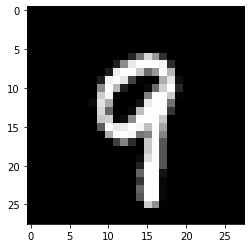

In [15]:
plt.imshow(picture, cmap='gray')
print("Target Label: ", 9)
print("Predicted Label: ", pred_label.item())

In [16]:
def test(model, device, test_loader, epsilon, target):
    results = np.zeros(10)
    wrong = 0
    count = 0
    correct = 0
    num_identified = 0
    adv_examples = []
    target = torch.tensor([target]).to(device)

    for data in test_loader:
        data = data.to(device)

        data.requires_grad = True

        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        #If prediction is already wrong go to next item
        if init_pred.item() != target.item():
            wrong += 1
            continue
        
        #Creates Adversarial Image
        for i in range(40):
            if output.max(1, keepdim=True)[1].item() != target.item() or epsilon == 0:
                break
            loss = F.cross_entropy(output, target)

            model.zero_grad()
            loss.backward()

            data_grad = data.grad.data.sign()

            perturbed_image = data + epsilon*data_grad

            perturbed_image = torch.clamp(perturbed_image, 0, 1)

            data = perturbed_image.clone().detach()
            
            data.requires_grad_()
            
            output = model(data)

            count += 1

        final_pred = output.max(1, keepdim=True)[1]

        #Adds adversarial examples if wrong
        if final_pred.item() == target.item():
            correct += 1

            if (epsilon == 0) and (len(adv_examples) < 10):
                adv_ex = data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        
        else:
            results[final_pred.item()] += 1
            if len(adv_examples) < 10:
                adv_ex = perturbed_image.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        
    final_acc = correct/float(len(test_loader))
    cycles_per = count/float(len(test_loader)-wrong)
    print("Number: {}\tTest Accuracy = {} / {} = {:.4f}\tCycles per image = {:.4f}\tAdversarial Result Frequencies = {}".format(target.item(), correct, len(test_loader), final_acc, cycles_per, results))

    return final_acc, adv_examples, cycles_per, results

In [30]:
%%time
accuracies = []
examples = []
cycles = []
results = np.zeros(10)
epsilon = .0075
for target, dl in enumerate(proc_data):
    acc, ex, cyc, res = test(model, device, dl, epsilon, target)
    accuracies.append(acc)
    examples.append(ex)
    cycles.append(cyc)
    results = np.add(results, res)

Number: 0	Test Accuracy = 8 / 980 = 0.0082	Cycles per image = 25.7932	Adversarial Result Frequencies = [  0.  41. 133.  73.  39. 217. 139.   8. 248.  66.]
Number: 1	Test Accuracy = 0 / 1135 = 0.0000	Cycles per image = 19.0915	Adversarial Result Frequencies = [  0.   0. 189.  70.   0.  20.   9.  26. 812.   0.]
Number: 2	Test Accuracy = 3 / 1032 = 0.0029	Cycles per image = 23.0991	Adversarial Result Frequencies = [ 21. 119.   0. 146.  30.   5.  38.  37. 597.  23.]
Number: 3	Test Accuracy = 0 / 1010 = 0.0000	Cycles per image = 19.2186	Adversarial Result Frequencies = [ 43.  24. 159.   0.   2. 323.   0.  20. 399.  18.]
Number: 4	Test Accuracy = 0 / 982 = 0.0000	Cycles per image = 18.1553	Adversarial Result Frequencies = [ 12.  20.  74.   2.   0.  16.  30.  10. 358. 450.]
Number: 5	Test Accuracy = 0 / 892 = 0.0000	Cycles per image = 19.6876	Adversarial Result Frequencies = [ 36.  20.  15. 143.   8.   0.  51.   8. 578.  18.]
Number: 6	Test Accuracy = 0 / 958 = 0.0000	Cycles per image = 21.32

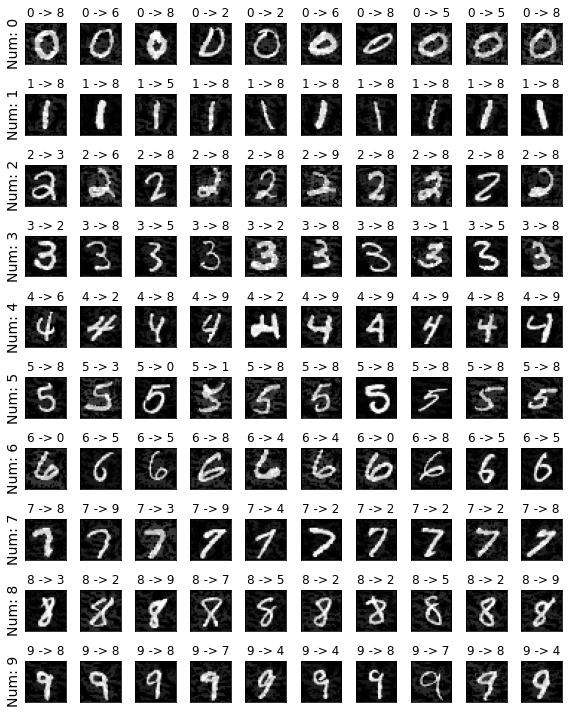

In [31]:
numbers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(numbers)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(numbers),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Num: {}".format(numbers[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

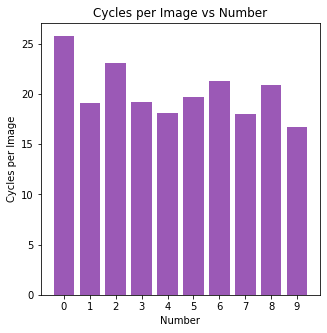

In [32]:
plt.figure(figsize=(5,5))
plt.bar(numbers, cycles)
#plt.yticks(np.arange(15, 30, step=1))
plt.xticks(np.arange(0, numbers[-1] + 1, step=1))
plt.title("Cycles per Image vs Number")
plt.xlabel("Number")
plt.ylabel("Cycles per Image")
plt.show()

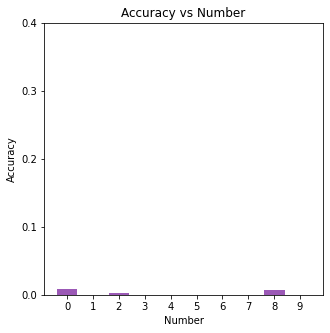

In [33]:
plt.figure(figsize=(5,5))
plt.bar(numbers, accuracies)
plt.yticks(np.arange(0, .5, step=0.1))
plt.xticks(np.arange(0, numbers[-1] + 1, step=1))
plt.title("Accuracy vs Number")
plt.xlabel("Number")
plt.ylabel("Accuracy")
plt.show()

In [34]:
import pandas as pd

df = pd.read_csv("Entropies.csv", index_col=0)
print(df)

   Entropies
0   2.328754
1   1.207942
2   2.139582
3   2.104382
4   1.893830
5   2.032034
6   2.081744
7   1.742740
8   2.249349
9   1.921577


In [35]:
import seaborn as sns

In [36]:
df["Accuracies"] = accuracies
df["Cycles"] = cycles
df["label"] = numbers
df["adv"] = results

In [37]:
cov1 = np.corrcoef(df["Entropies"], df["Accuracies"])
cov2 = np.corrcoef(df["Entropies"], df["Cycles"])
cov3 = np.corrcoef(df["Entropies"], df["adv"])

def R(cov):
    return cov[0][1]/np.sqrt(cov[0][0]*cov[1][1])

print(R(cov1))
print(R(cov2))
print(R(cov3))

0.5883581599741349
0.5625668958400281
0.3790941009544747


In [1]:
flatui = ["#9b59b6", "#3498db", "orange"]
sns.set_palette(flatui)
sns.lmplot( x="Entropies", y="Accuracies", data=df, fit_reg=True, height=5,
           hue='label', legend=True)

plt.figure(figsize=(10,10))

#The more random the data is the harder it is to create an adversarial example as shown below

NameError: name 'sns' is not defined